$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

In [1]:
#Imports
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
!pip install optax
import optax

In [2]:
N_0 = 100
N_b = 100
N_r = 10_000

tmin,tmax=0. ,1.
xmin,xmax = -1.,1.

'''boundary conditions'''


# U[0,x] = -sin(pi*x)
t_0 = jnp.ones([N_0,1],dtype='float32')*0.
x_0 = np.random.uniform(low=xmin,high=xmax,size=(N_0,1))
ic_0 = -jnp.sin(jnp.pi*x_0)
IC_0 = jnp.concatenate([t_0,x_0,ic_0],axis=1)

# U[t,-1] = 0
t_b1 = np.random.uniform(low=tmin,high=tmax,size=(N_b,1))
x_b1 = jnp.ones_like(t_b1) *-1
bc_1 = jnp.zeros_like(t_b1)
BC_1 = jnp.concatenate([t_b1,x_b1,bc_1],axis=1)

# U[t,1] = 0
t_b2 = np.random.uniform(low=tmin,high=tmax,size=(N_b,1))
x_b2 = jnp.ones_like(t_b2)
bc_2 = jnp.zeros_like(t_b2)
BC_2 = jnp.concatenate([t_b2,x_b2,bc_2],axis=1)

conds = [IC_0,BC_1,BC_2]

#collocation points
t_c = np.random.uniform(low=tmin,high=tmax,size=(N_r,1))
x_c = np.random.uniform(low=xmin,high=xmax,size=(N_r,1))
colloc = jnp.concatenate([t_c,x_c],axis=1)

<ipython-input-6-353ec9e1fa07>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(t_c, x_c, c='k', marker='.', alpha=0.2,label='Collocation points',cmap=cm.jet)
<ipython-input-6-353ec9e1fa07>:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))


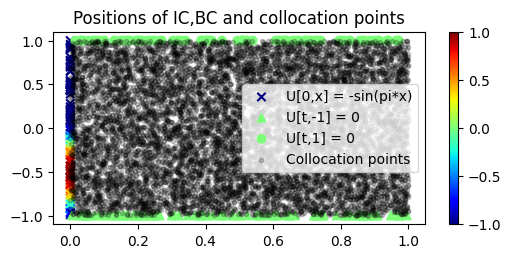

In [6]:
fig = plt.figure(figsize=(6,2.5))
plt.scatter(t_0, x_0, c=ic_0, marker='x', vmin=0, vmax=1,label='U[0,x] = -sin(pi*x)',cmap=cm.jet)
plt.scatter(t_b1, x_b1, c=bc_1, marker='^', vmin=-1, vmax=1,label='U[t,-1] = 0',cmap=cm.jet)
plt.scatter(t_b2, x_b2, c=bc_2, marker='o', vmin=-1, vmax=1,label='U[t,1] = 0',cmap=cm.jet)


cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=-1, vmax=1)


plt.scatter(t_c, x_c, c='k', marker='.', alpha=0.2,label='Collocation points',cmap=cm.jet)
plt.xlabel('')
plt.ylabel('')

plt.title('Positions of IC,BC and collocation points');
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.legend(loc='center right')

In [3]:

def PDE_loss(t,x,u):
  u_x=lambda t,x:jax.grad(lambda t,x:jnp.sum(u(t,x)),1)(t,x)
  u_xx=lambda t,x:jax.grad(lambda t,x : jnp.sum(u_x(t,x)),1)(t,x)
  u_t=lambda t,x:jax.grad(lambda t,x:jnp.sum(u(t,x)),0)(t,x)
  return u_t(t,x) + u(t,x)*u_x(t,x) - (0.01/jnp.pi)*u_xx(t,x)

In [7]:
def init_params(layers):
  keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
    lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in)) # xavier initialization lower and upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
    B = jax.random.uniform(key,shape=(n_out,))
    params.append({'W':W,'B':B})
  return params


In [8]:
def fwd(params,t,x):
  X = jnp.concatenate([t,x],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

In [9]:
@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)



In [11]:
def loss_fun(params,colloc,conds):
  t_c,x_c =colloc[:,[0]],colloc[:,[1]]
  ufunc = lambda t,x : fwd(params,t,x)
  loss =jnp.mean(PDE_loss(t_c,x_c,ufunc) **2)

  for cond in conds :
    t_b,x_b,u_b = cond[:,[0]],cond[:,[1]],cond[:,[2]]
    loss += MSE(u_b,ufunc(t_b,x_b))
  return  loss

In [12]:
@jax.jit
def update(opt_state,params,colloc,conds):
  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds)

  #Update params
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  #Update params
  # return jax.tree_multimap(lambda params,grads : params-LR*grads, params,grads)
  return opt_state,params

In [13]:


# construct the MLP of  6 hidden layers of 8 neurons for each layer
params = init_params([2] + [8]*6+[1])


lr = optax.piecewise_constant_schedule(1e-2,{10_000:5e-3,30_000:1e-3,50_000:5e-4,70_000:1e-4})
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)



In [14]:
%%time
epochs = 20_000
for _ in range(epochs):
  opt_state,params = update(opt_state,params,colloc,conds)

  # print loss and epoch info
  if _ %(100) ==0:
    print(f'Epoch={_}\tloss={loss_fun(params,colloc,conds):.3e}')


Epoch=0	loss=2.771e+00
Epoch=100	loss=3.095e-01
Epoch=200	loss=1.860e-01
Epoch=300	loss=6.673e-02
Epoch=400	loss=4.243e-02
Epoch=500	loss=3.560e-02
Epoch=600	loss=3.255e-02
Epoch=700	loss=4.225e-02
Epoch=800	loss=2.602e-02
Epoch=900	loss=6.552e-02
Epoch=1000	loss=2.174e-02
Epoch=1100	loss=1.669e-02
Epoch=1200	loss=7.670e-02
Epoch=1300	loss=1.768e-02
Epoch=1400	loss=2.098e-02
Epoch=1500	loss=1.358e-02
Epoch=1600	loss=1.205e-02
Epoch=1700	loss=1.010e-02
Epoch=1800	loss=9.216e-03
Epoch=1900	loss=8.550e-03
Epoch=2000	loss=1.263e-02
Epoch=2100	loss=7.642e-03
Epoch=2200	loss=7.625e-03
Epoch=2300	loss=7.569e-03
Epoch=2400	loss=6.896e-03
Epoch=2500	loss=5.518e-03
Epoch=2600	loss=6.878e-03
Epoch=2700	loss=4.883e-03
Epoch=2800	loss=6.558e-03
Epoch=2900	loss=4.919e-03
Epoch=3000	loss=4.128e-03
Epoch=3100	loss=5.021e-03
Epoch=3200	loss=4.082e-03
Epoch=3300	loss=6.744e-03
Epoch=3400	loss=3.892e-03
Epoch=3500	loss=6.977e-03
Epoch=3600	loss=3.945e-03
Epoch=3700	loss=4.637e-03
Epoch=3800	loss=3.396e-0

In [19]:
def plot2D(T,X, p):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, p[:],  cmap=cm.viridis)
    ax.set_xlim(tmin, tmax)
    ax.set_ylim(xmin, xmax)
    ax.view_init(35,35)
    ax.set_xlabel('')
    ax.set_ylabel('')

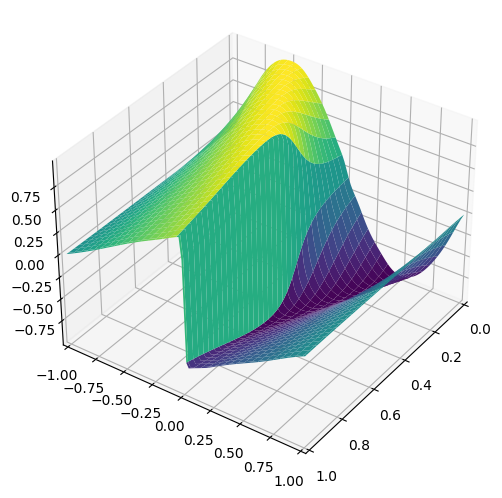

In [22]:
N = 100
tspace = np.linspace(tmin, tmax, N + 1)
xspace = np.linspace(xmin, xmax, N + 1)
T, X = np.meshgrid(tspace, xspace)

# Determine predictions of u(t, x)
upred = fwd(params,T.flatten().reshape(-1,1),X.flatten().reshape(-1,1))

# Reshape upred
U = upred.reshape(N+1,N+1)
plot2D(T,X,U)

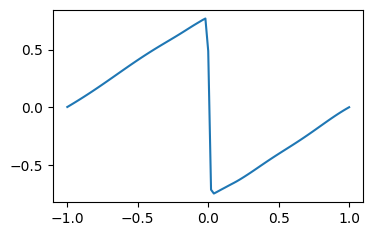

In [24]:
fig = plt.figure(figsize=(4,2.5))
tspace= 0.9
xspace = np.linspace(-1, 1, N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T
upred = fwd(params,T.flatten().reshape(-1,1),X.flatten().reshape(-1,1))
# Reshape upred
plt.plot(X,upred)